<a href="https://colab.research.google.com/github/HyeongChanHam/hand_project/blob/master/topic_1_%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision - Final Project

* Team member
  - 함형찬 (20171263)
  - 이도경 (20141736)
  - 김민제 (20171036)

## Setting for colab

- If running environment is google colab, set env variable as 'colab'
- else (running at local), set env variable to others

In [ ]:
env = 'colab'
if env=='colab':
    from google.colab import drive
    drive.mount('/content/gdrive')
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

Mounted at /content/gdrive


In [ ]:
import torch
import numpy as np
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
from google.colab.patches import cv2_imshow
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import models
from sklearn.model_selection import train_test_split # for cross-validation
from sklearn.model_selection import StratifiedKFold # for cross-validation
from glob import glob

In [ ]:
categories = ['brontosaurus', 'car_side', 'cougar_face', 'dalmatian', 'dollar_bill',
              'dragonfly', 'Faces', 'Faces_easy', 'flamingo', 'headphone',
              'lotus', 'menorah', 'nautilus', 'pagoda', 'soccer_ball',
              'stop_sign', 'sunflower', 'tick', 'windsor_chair', 'yin_yang']

# the number of whole training (train + validation) images
training_num_imgs = 30
# ratio of the number of validation
val_split_ratio = 0.2

train_img_len = int(training_num_imgs * (1-val_split_ratio))
val_img_len = int(training_num_imgs * val_split_ratio)

#the number of testing images
test_img_len = 5
num_of_classes = 20
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Dataset for images
- reshape the image size
- label them as each category number

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, method=None, split_idxes=None):
        #self.root = '/content/gdrive/My Drive/'
        self.root = '/content/gdrive/My Drive/computer vision/'
        self.x_data = []
        self.y_data = []
        self.img_path = []

        assert split_idxes is not None

        if method == 'train':
            length = train_img_len
            self.root = self.root + 'dataset/train'
            
        elif method == 'val':
            length = val_img_len
            self.root = self.root + 'dataset/train'

        else:
            length = test_img_len
            self.root = self.root + 'dataset/test'
        
        for cat_idx, category in tqdm(enumerate(categories), total=num_of_classes):
            dir_path = self.root + '/' + category + '/'
            for img_idx, img_p in enumerate(sorted(glob(dir_path + '*.jpg'))):
                if img_idx not in split_idxes[cat_idx]:
                    continue
                img = cv2.imread(img_p)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                self.x_data.append(img)
                self.y_data.append(cat_idx)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        transform1 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),                 
        ])
        new_x_data = transform1(self.x_data[idx])
        return new_x_data, self.y_data[idx]

    def return_whole(self):
        transform1 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),                 
        ])
        new_x_data = []
        for i in range(train_img_len * num_of_classes):
            new_x_data.append(transform1(self.x_data[i]))

        return new_x_data, self.y_data

## Traning class

In [ ]:
class Trainer(object):
    def __init__(self, epochs, batch_size, lr):

        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = lr
        self._build_model()

        """
        split train_val idxes
        """
        indices = np.array([x for x in range(training_num_imgs)])
        train_indices = list()
        val_indices = list()
        for _ in range(num_of_classes):
            val_idx = np.random.choice(indices, val_img_len, replace=False)
            train_idx = np.setdiff1d(indices, val_idx)
            train_indices.append(train_idx)
            val_indices.append(val_idx)



        self.dataset = ImgDataset(method='train', split_idxes=train_indices)
        self.val_dataset = ImgDataset(method='val', split_idxes=val_indices)
        self.root = self.dataset.root
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

        weight_PATH = self.root.split('/')
        del weight_PATH[-1]
        del weight_PATH[-1]
        
        self.weight_PATH = "/".join(weight_PATH)
        self.weight_PATH = self.weight_PATH + "/dataset/"
        print("weightPATH: ",self.weight_PATH)

        # Load of pretrained_weight file
        # weight_PATH = '/content/gdrive/My Drive/
        # self.poseNet.load_state_dict(torch.load(weight_PATH))

        print("Training...")

    def _build_model(self):
        net = models.resnet18(pretrained=True)

        """
        freeze feature extraction layers, except classifier
        """
        for p in net.parameters():
            p.requires_grad = False

        net.fc = torch.nn.Linear(in_features = net.fc.in_features, out_features=num_of_classes)

        self.resnet = net.to(device)
        self.resnet.train()

        print('Finish build model.')

    def return_whole_training_img(self):
        return self.dataset.return_whole()

    def train(self):
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.resnet.parameters(), lr=self.learning_rate)

        self.losses = []
        self.val_losses = []
        for epoch in tqdm(range(self.epochs + 1)):
            print("epoch ",epoch)
            train_loss = 0

            for batch_idx, samples in enumerate(self.dataloader):
                optimizer.zero_grad()
                x_train, y_train = samples
                x_train, y_train = x_train.to(device), y_train.to(device)
                result_resnet = self.resnet(x_train)

                loss = loss_func(result_resnet, y_train)
                train_loss += loss.item()
                loss.backward()
                optimizer.step()

            self.losses.append(train_loss/batch_idx)

            val_loss = 0
            for batch_idx, samples in enumerate(self.val_dataloader):
                x_train, y_train = samples
                x_train, y_train = x_train.to(device), y_train.to(device)
                result_resnet = self.resnet(x_train)

                loss = loss_func(result_resnet, y_train)
                val_loss += loss.item()

            self.val_losses.append(val_loss/batch_idx)
            print("training loss: {}, val loss: {}".format(train_loss/batch_idx, val_loss/batch_idx))
        print('Finish training.\n')
        torch.save(self.resnet.state_dict(), "".join([self.weight_PATH,'modelweight.pth']))
        print("model saved at ","".join([self.weight_PATH,'modelweight.pth']))

    
class Tester(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self._build_model()
        test_indices = [[x for x in range(test_img_len)] for _ in range(num_of_classes)]
        dataset = ImgDataset(method='test', split_idxes=test_indices)
        self.root = dataset.root
        self.dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        self.datalen = dataset.__len__()
        self.correct = 0

        # load the weight
        weight_PATH = '/content/gdrive/My Drive/computer vision/dataset/modelweight.pth'
        self.resnet.load_state_dict(torch.load(weight_PATH))

        print("Testing...")

    def _build_model(self):
        net = models.resnet18()

        """
        freeze feature extraction layers, except classifier
        """
        for p in net.parameters():
            p.requires_grad = False

        net.fc = torch.nn.Linear(in_features = net.fc.in_features, out_features=num_of_classes)

        self.resnet = net.to(device)
        self.resnet.eval()

        print('Finish build model.')

    def test(self):
        for batch_idx, samples in enumerate(self.dataloader):
            x_test, y_test = samples
            x_test, y_test = x_test.to(device), y_test.to(device)
        
            output = self.resnet(x_test)
            r = output.argmax(dim=1)
            self.correct+=(y_test==r).sum().item()
            
        print('total : ', self.datalen)
        print("Accuracy {}".format(self.correct/self.datalen))

## Testing class

In [ ]:
batchSize_candidate = [100,50,20,10] 
learningRate_candidate = [1e-3,1e-2,1e-1]

epochs_ = 50
batchSize_ = 8
learningRate_ = 1e-3

trainer = Trainer(epochs_, batchSize_, learningRate_)
trainer.train()

tester = Tester(batchSize_)
tester.test()

Finish build model.



weightPATH:  /content/gdrive/My Drive/computer vision/dataset/
Training...


epoch  0
training loss: 13.28895594392504, val loss: 3.1350972993033275
epoch  1
training loss: 12.036246265683856, val loss: 2.9205305576324463
epoch  2
training loss: 10.912797127451215, val loss: 2.7051160505839755
epoch  3
training loss: 9.901245474815369, val loss: 2.443967887333461
epoch  4
training loss: 9.01377557005201, val loss: 2.28594457251685
epoch  5
training loss: 8.1456601193973, val loss: 2.0686385290963307
epoch  6
training loss: 7.430843787533896, val loss: 1.9420907412256514
epoch  7
training loss: 6.849794983863831, val loss: 1.786432649408068
epoch  8
training loss: 6.241818172591073, val loss: 1.6951888118471419
epoch  9
training loss: 5.66734652859824, val loss: 1.6256161076681954
epoch  10
training loss: 5.216915760721479, val loss: 1.518592621598925
epoch  11
training loss: 4.932804878268923, val loss: 1.4497396647930145
epoch  12
training loss: 4.558672449418476, val loss: 1.2549253787313188
epoch  13
training loss: 4.2324530737740655, val loss: 1.27477303573


Testing...
total :  100
Accuracy 0.99


## Plot training / validation loss

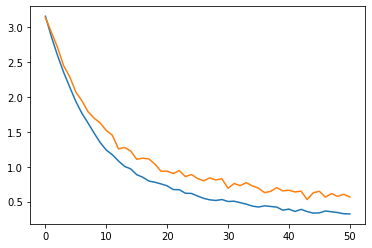

In [ ]:
plt.plot(trainer.losses, label='train_loss')
plt.plot(trainer.val_losses, label='val_loss')
plt.show()

## Evaluate trained model

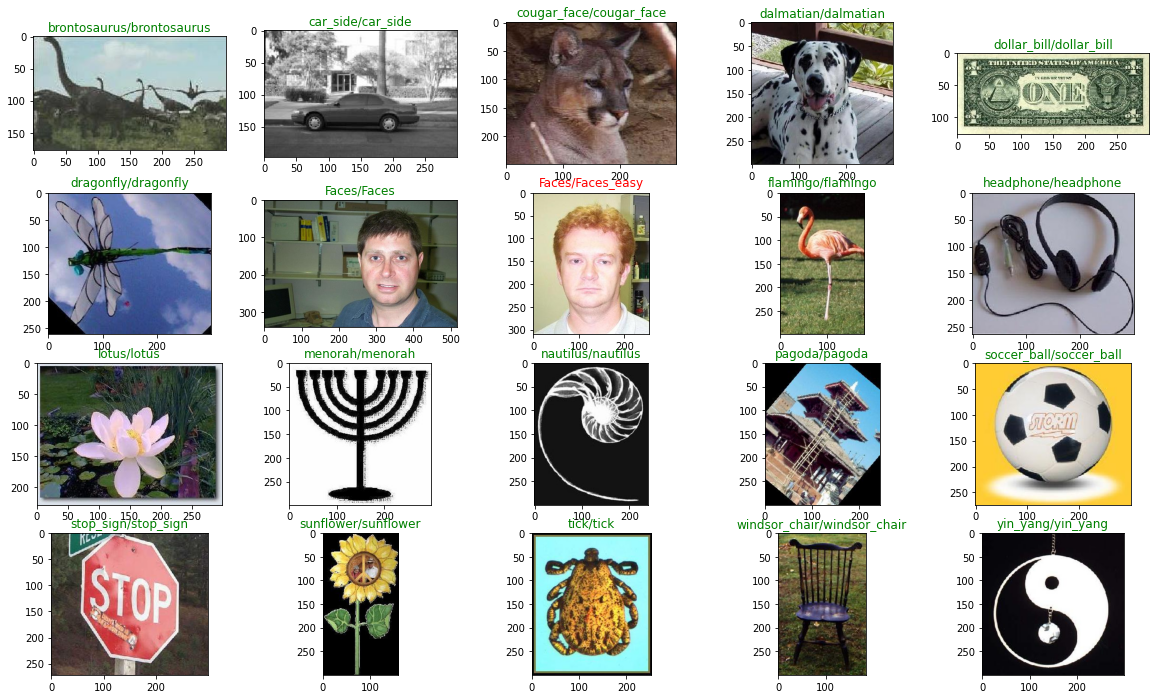

In [ ]:
import matplotlib.pyplot as plt

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),                 
])
fig, ax = plt.subplots(4,5)
fig.set_figwidth(20)
fig.set_figheight(12)
for idx, cat in enumerate(categories):
    imgs = next(os.walk(os.path.join(tester.root, cat)))[2]
    one_img = np.random.choice(imgs, 1)[0]
    img_path = os.path.join(tester.root, cat, one_img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input = transform1(img).unsqueeze(dim=0).to(device)
    pred = tester.resnet(input)
    pred_idx = pred.argmax(dim=1)
    ax[idx//5,idx%5].imshow(img)
    title_obj = ax[idx//5,idx%5].set_title("{}/{}".format(categories[pred_idx], cat))
    if categories[pred_idx]==cat:
        plt.setp(title_obj, color='green')
    else:
        plt.setp(title_obj, color='red')
plt.show()
